In [ ]:
%pip install pandas==1.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 30.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
#from custom_scorer_module import custom_accuracy
%matplotlib inline
import pickle
#from langdetect import detect
from sklearn.metrics import fbeta_score, make_scorer, mean_poisson_deviance
%load_ext autoreload
%autoreload 2
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OrdinalEncoder

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [ ]:
#Computes mean poisson deviance but makes sure that our predictions is positive
def evaluate_model(y_true,y_pred):
    prediction=y_pred.copy()
    prediction[prediction<=0]=10**(-10)
    return mean_poisson_deviance(y_true,prediction)


In [ ]:
#Define a scoring method that sklearn can use for crossvalidation
scoring=make_scorer(evaluate_model,greater_is_better=False)

In [ ]:
# when using this this notebook on colab, the most efficient way to access the data is to have them stored on your drive (if working on local we don't need to use this cell)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#The path of the data: (as I am using drive, colab access it via the path /content/drive/MyDrive/)
PATH='/content/drive/MyDrive/Data/'

In [ ]:
with open(PATH+"listings.pkl", "rb") as fh:
    data = pickle.load(fh)
with open(PATH+"test_listings_tabular.pkl", "rb") as fh:
    data_test = pickle.load(fh)
#with open("./listings.pkl", "rb") as fh:
#    data = pickle.load(fh)
with open(PATH+"test_listings_overall.pkl", "rb") as fh:
    data_test_overall = pickle.load(fh)
data_tabular=data.drop(['Listing Description','Listing Title','Property Reference Id'],axis=1)

In [ ]:
#Initialising a random seed for reproducibility
seed=np.random.randint(100)
#Creating dictionaries to encode categories into integers
DICT_GEO_CANTON={'ZH':0, 'VD':1, 'BE':2, 'AG':3, 'FR':4, 'SG':5, 'LU':6, 'SO':7, 'SH':8, 'GE':9, 'VS':10,
       'SZ':11, 'BS':12, 'ZG':13, 'BL':14, 'NE':15, 'TI':16, 'GR':17, 'TG':18, 'AR':19, 'UR':20, 'GL':21,
       'NW':22, 'JU':22}
DICT_SUBCATEGORY={'Apartment':0, 'Duplex':1, 'Row house':2, 'Roof flat':3, 'Attic flat':4,
       'Single house':5, 'Single Room':6, 'Studio':7, 'Furnished dwelling':8,
       'Loft':9, 'Mansard':10, 'Farm house':11}
DICT_CATEGORY_IDX={'APPT':0,'HOUSE':1}
geo_values=data['Geo City'].unique()
DICT_GEO_CITY= {geo_values[i]: [x for x in range(0,len(geo_values))][i] for i in range(len(geo_values))}
geo_zip_val=data['Geo Zip'].unique()
DICT_GEO_ZIP= {geo_zip_val[i]: [x for x in range(0,len(geo_zip_val))][i] for i in range(len(geo_zip_val))}

# Data Cleaning

There are some things to consider before starting using the random forest:  
1-**How to deal with NaN**  
  Answer: check if there are NaN in test set, if yes can make a category for NaN?  
          What does NaN mean? Customer doesn't have access to the information? Or we don't know if he had access to it?  
2-**How to deal with categorical variables**  
  One hot encoding, but beware of having too many categories.  
  Testing without categorical variables?  

## Identifying categorical and categorical variables

In [ ]:
#identifying the boolean variables
bool_features=['Are Pets Allowed', 'Has Balcony', 'Has Cabletv',
               'Has Elevator', 'Has Fireplace', 'Has Garage',
               'Has Parking', 'Is New Construction', 'Is New Construction Potential', 
               'Is Tenant2Tenant', 'Is Wheelchairaccessible']
print(bool_features)
data_bool=data[bool_features]

['Are Pets Allowed', 'Has Balcony', 'Has Cabletv', 'Has Elevator', 'Has Fireplace', 'Has Garage', 'Has Parking', 'Is New Construction', 'Is New Construction Potential', 'Is Tenant2Tenant', 'Is Wheelchairaccessible']


Identifying other categorical (and non ordinal ex: Number of Rooms, Price Extra Normalized or even Year Built...) variables with not so many categories

In [ ]:
data_tabular.columns

Index(['Are Pets Allowed', 'Category Idx', 'Day of Advertisement Created',
       'Day of Date Available From', 'Demand', 'Floor', 'Geo Canton',
       'Geo City', 'Geo Zip', 'Has Balcony', 'Has Cabletv', 'Has Elevator',
       'Has Fireplace', 'Has Garage', 'Has Parking', 'Is New Construction',
       'Is New Construction Potential', 'Is Tenant2Tenant',
       'Is Wheelchairaccessible', 'Jahr', 'Leerwohnungsziffer', 'Livingspace',
       'Number Of Rooms', 'Number Of Rooms Cleaned', 'Number of Documents',
       'Number of Images', 'Price Extra Normalized', 'Price Gross Normalized',
       'Price M2 Normalized', 'Price Net Normalized', 'Size M2 Normalized',
       'Subcategory En Idx', 'Year Built', 'Year Lastrenovated'],
      dtype='object')

### Investigating the NaN

In [ ]:
other_categorical_features=['Category Idx','Geo City','Geo Zip']

#The ordinal features are:
ordinal_features=['Floor','Jahr', 'Leerwohnungsziffer','Livingspace', 'Number Of Rooms',
       'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
       'Price Extra Normalized', 'Price Gross Normalized',
       'Price M2 Normalized', 'Price Net Normalized', 
       'Size M2 Normalized', 'Year Built',
       'Year Lastrenovated',]

categorical_features={'Geo Canton':DICT_GEO_CANTON,'Subcategory En Idx':DICT_SUBCATEGORY}



# Preprocessing pipeline with one hot encoding

In [ ]:
#https://towardsdatascience.com/predicting-housing-prices-using-a-scikit-learns-random-forest-model-e736b59d56c5
#https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer


In [ ]:
#Extract numerical features from 'Day of Advertisement Created', 'Day of Date Available From',
def adding_features(X: pd.DataFrame, y=None):
    X_copy=X.copy()
    threshold=datetime.datetime(2022,9,1)
    X_copy['Days Between September and Created']=pd.to_datetime(X_copy['Day of Advertisement Created']).apply(lambda x:(threshold-x).days)
    X_copy['Days Between September and Available']=pd.to_datetime(X_copy['Day of Date Available From']).apply(lambda x:(threshold-x).days)                                                           
    X_copy.drop(['Day of Advertisement Created','Day of Date Available From'],axis=1,inplace=True)
    
    #X_copy['Len Description']=X_copy['Listing Description'].apply(lambda x:len_text(x))
    X_copy=X_copy.drop(['Geo City'],axis=1)
    X_copy['Leerwohnungsziffer']=X_copy['Leerwohnungsziffer'].astype('float')
                
    return X_copy

adding_features_transformer = FunctionTransformer(adding_features)

print('Transforming features')
display(adding_features_transformer.transform(data_tabular))

In [ ]:
categorical_features={'Category Idx':DICT_CATEGORY_IDX,'Geo Zip':DICT_GEO_ZIP,'Geo Canton':DICT_GEO_CANTON,'Subcategory En Idx':DICT_SUBCATEGORY}
#DEALING WITH NAN
def fill_nan(X: pd.DataFrame,bool_features,categorical_features,ordinal_features,bool_fill=-99999, y=None):
    df=X.copy() #We don't want to modify the dataset
    
    #Dealing with categorical values
    for bool_feature in bool_features:
        df.loc[:,bool_feature]=df.loc[:,bool_feature].fillna(bool_fill)
        df.loc[df[bool_feature] == False, bool_feature] = 0
        df.loc[df[bool_feature] == True, bool_feature] = 1
        #df[bool_feature]=df[bool_feature].astype('category')
    
    #Dealing with ordinal values
    for ordinal_feature in ordinal_features:
        df[ordinal_feature].fillna(df[ordinal_feature].mean(),inplace=True)
        
    #Dealing with categorical features
    for categorical_feature in categorical_features.keys():
        dict_replace=categorical_features[categorical_feature]
        df[categorical_feature]=df[categorical_feature].map(dict_replace)
        df[categorical_feature].fillna(len(dict_replace)+1,inplace=True)
        #df[categorical_feature].fillna(bool_fill,inplace=True)
        #df[categorical_feature]=df[categorical_feature].astype('category')
    return df

na_fill_estimator = FunctionTransformer(fill_nan,kw_args={'bool_features':bool_features,
                                                          'categorical_features':categorical_features,
                                'ordinal_features':ordinal_features+['Days Between September and Created',
                                                                     'Days Between September and Available']})

print('Dealing with NaN')
display(na_fill_estimator.transform(adding_features_transformer.transform(data_tabular)))

In [ ]:
#One Hot Encoding

features_to_encode=bool_features+list(categorical_features.keys())

col_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown = 'ignore'),features_to_encode),
                        remainder = "passthrough"
                        )
print('One Hot Encoded data:')
test=col_trans.fit_transform( \
    na_fill_estimator.transform(adding_features_transformer.transform(data_tabular)))
print(col_trans.fit_transform( \
    na_fill_estimator.transform(adding_features_transformer.transform(data_tabular))))
print(col_trans.fit_transform(\
    na_fill_estimator.transform(adding_features_transformer.transform(data_tabular))).shape)

One Hot Encoded data:
  (0, 0)	1.0
  (0, 3)	1.0
  (0, 6)	1.0
  (0, 9)	1.0
  (0, 12)	1.0
  (0, 15)	1.0
  (0, 18)	1.0
  (0, 22)	1.0
  (0, 24)	1.0
  (0, 26)	1.0
  (0, 28)	1.0
  (0, 31)	1.0
  (0, 33)	1.0
  (0, 483)	1.0
  (0, 506)	1.0
  (0, 518)	25.0
  (0, 520)	2021.0
  (0, 521)	1.37
  (0, 522)	232.0
  (0, 523)	9.5
  (0, 524)	9.5
  (0, 525)	1.0
  (0, 526)	6.0
  (0, 527)	550.0
  (0, 528)	4460.0
  :	:
  (19999, 21)	1.0
  (19999, 24)	1.0
  (19999, 26)	1.0
  (19999, 29)	1.0
  (19999, 31)	1.0
  (19999, 235)	1.0
  (19999, 501)	1.0
  (19999, 506)	1.0
  (19999, 518)	3.0
  (19999, 520)	2017.0
  (19999, 521)	0.89
  (19999, 522)	52.0
  (19999, 523)	2.0
  (19999, 524)	2.0
  (19999, 525)	1.0
  (19999, 526)	5.0
  (19999, 527)	130.0
  (19999, 528)	845.0
  (19999, 529)	16.0
  (19999, 530)	715.0
  (19999, 531)	52.0
  (19999, 532)	1976.683963319168
  (19999, 533)	1991.7910962715637
  (19999, 534)	1939.0
  (19999, 535)	1826.0
(20000, 536)


# Random forest

In [ ]:
rf_regressor=RandomForestRegressor(oob_score=True,n_estimators=500,min_samples_split=3,
                      n_jobs=-1)

#We use a pipeline to combine the preprcessing with the model
pipe = make_pipeline(adding_features_transformer,na_fill_estimator, col_trans,rf_regressor)

In [ ]:
#Generating test and train set
X=data_tabular.drop('Demand',axis=1)

y=data_tabular['Demand']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, 
                                                    random_state = seed
                                                   )
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(13340, 33) (13340,) (6660, 33) (6660,)


In [ ]:
#Takes a while to run
print('Out of sample mean poisson deviance by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring,n_jobs=-1).mean())

Out of sample mean poisson deviance by cross validation: -5.094163124848156


In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function adding_features at 0x7fc30fc9d550>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function fill_nan at 0x7fc30fd76040>,
                                     kw_args={'bool_features': ['Are Pets '
                                                                'Allowed',
                                                                'Has Balcony',
                                                                'Has Cabletv',
                                                                'Has Elevator',
                                                                'Has Fireplace',
                                                                'Has Garage',
                                                                'Has Parking',
                                                                'Is New '
                                            

In [ ]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.0881
Out of Sample mean poisson deviance 5.3588


In [ ]:
#To sibmit results
'''
predictions=pipe.predict(data_test.drop('Prediction',axis=1))
predictions[np.where(predictions<=0)]=10**(-10)
data_test['Prediction']=predictions
with open(PATH+"tabular_pred2.pickle", "wb") as f:
    pickle.dump(data_test, f)
'''
print('')

# Random forest without one hot encoding

In [ ]:
pipe = make_pipeline(adding_features_transformer,na_fill_estimator,rf_regressor)
cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean()


-5.436416058481086

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function adding_features at 0x7fc30fc9d550>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function fill_nan at 0x7fc30fd76040>,
                                     kw_args={'bool_features': ['Are Pets '
                                                                'Allowed',
                                                                'Has Balcony',
                                                                'Has Cabletv',
                                                                'Has Elevator',
                                                                'Has Fireplace',
                                                                'Has Garage',
                                                                'Has Parking',
                                                                'Is New '
                                            

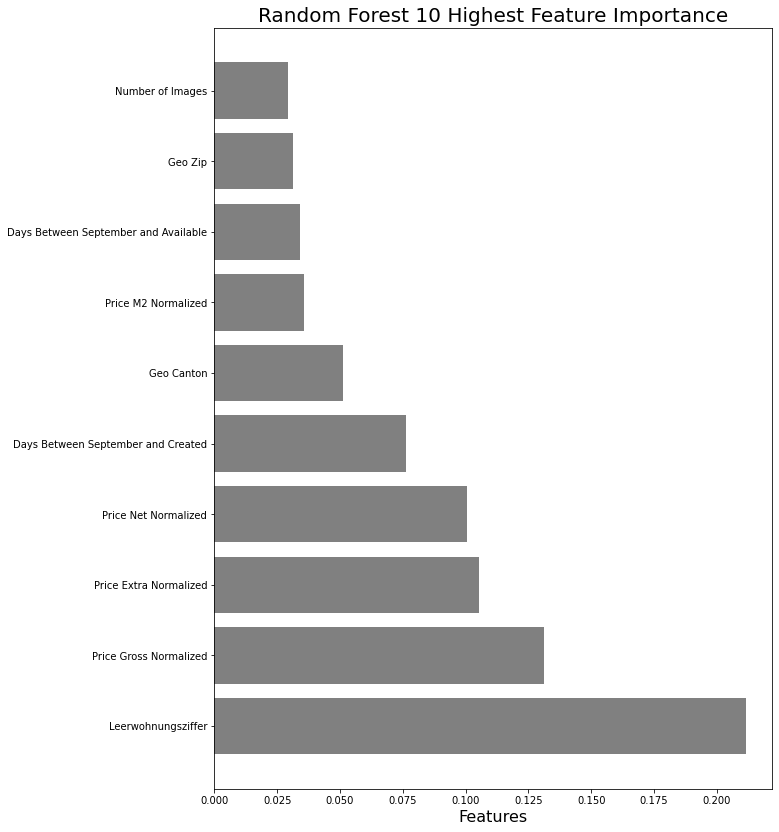

In [ ]:
feature_importances = list(zip(na_fill_estimator.transform(adding_features_transformer.transform(X_train)), rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 10 feature importance
feature_names_10 = [i[0] for i in feature_importances_ranked[:10]]
y_ticks = np.arange(0, len(feature_names_10))
x_axis = [i[1] for i in feature_importances_ranked[:10]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_10, x_axis,color='grey')   #horizontal barplot
plt.title('Random Forest 10 Highest Feature Importance',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.savefig(PATH+'Random Forest Features Importance.png',bbox_inches='tight')
plt.show()

In [ ]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.1546
Out of Sample mean poisson deviance 5.7040


**Conclusion** One hot encoding was giving better resuts than not one hot encoding

# Dropping the corrolated features

In [ ]:
#Removing size M2 Normalized, Number of Rooms and all price measure except extra price normalized:
ordinal_features=['Jahr','Leerwohnungsziffer','Floor','Livingspace', 
       'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
       'Price Extra Normalized', 'Year Built',
       'Year Lastrenovated','Len Description']

In [ ]:
def drop_column(X: pd.DataFrame,columns, y=None):
    X_copy=X.copy() #We don't want to modify the dataset
    X_copy.drop(columns,axis=1,inplace=True)
    
    return X_copy

drop_col_transformer = FunctionTransformer(drop_column,kw_args={'columns':['Price M2 Normalized','Price Gross Normalized',
                                                                           'Price Net Normalized','Size M2 Normalized',
                                                                           'Number Of Rooms']})
na_fill_estimator = FunctionTransformer(fill_nan,kw_args={'bool_features':bool_features,
                                                          'categorical_features':categorical_features,
                                                          'ordinal_features':ordinal_features+
                                                          ['Days Between September and Created',
                                                                     'Days Between September and Available']})

## 1 With One Hot encoding

In [ ]:
pipe= make_pipeline(drop_col_transformer,adding_features_transformer,na_fill_estimator,col_trans,rf_regressor)
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function drop_column at 0x000001B6A9C59040>,
                                     kw_args={'columns': ['Price M2 Normalized',
                                                          'Price Gross '
                                                          'Normalized',
                                                          'Price Net '
                                                          'Normalized',
                                                          'Size M2 Normalized',
                                                          'Number Of Rooms']})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function adding_features at 0x000001B6AA53FDC0>)),
                ('functiontransfo...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                        

In [ ]:
#X_train_encoded = encode_and_bind(na_fill_estimator.transform(diff_date_transformer.transform(drop_col_transformer.transform(X_train))), features_to_encode)
#feature_importances = list(zip(X_train_encoded, rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
#feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 25 feature importance
#feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
#y_ticks = np.arange(0, len(feature_names_25))
#x_axis = [i[1] for i in feature_importances_ranked[:25]]
#plt.figure(figsize = (10, 14))
#plt.barh(feature_names_25, x_axis)   #horizontal barplot
#plt.title('Random Forest Feature Importance without one hot encoding(Top 25)',
#          fontdict= {'fontsize' : 20})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
#plt.show()

In [ ]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.2126
Out of Sample mean poisson deviance 6.3811


In [ ]:
#print('Out of sample accuracy by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean())

## 2 Without One Hot encoding

In [ ]:
pipe= make_pipeline(drop_col_transformer,adding_features_transformer,na_fill_estimator,rf_regressor)
pipe.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function drop_column at 0x000001B6A9C59040>,
                                     kw_args={'columns': ['Price M2 Normalized',
                                                          'Price Gross '
                                                          'Normalized',
                                                          'Price Net '
                                                          'Normalized',
                                                          'Size M2 Normalized',
                                                          'Number Of Rooms']})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function adding_features at 0x000001B6AA53FDC0>)),
                ('functiontransfo...
                                                                   'Leerwohnungsziffer',
                                                                   'Floor',
  

In [ ]:
#feature_importances = list(zip(drop_col_transformer.transform(X_train), rf_regressor.feature_importances_))
# Then sort the feature importances by most important first
#feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Plot the top 25 feature importance
#feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
#y_ticks = np.arange(0, len(feature_names_25))
#x_axis = [i[1] for i in feature_importances_ranked[:25]]
#plt.figure(figsize = (10, 14))
#plt.barh(feature_names_25, x_axis)   #horizontal barplot
#plt.title('Random Forest Feature Importance without one hot encoding(Top 25)',
#          fontdict= {'fontsize' : 20})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
#plt.show()

In [ ]:
#Evaluate the model
print('In Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_train,pipe.predict(X_train))))
print('Out of Sample mean poisson deviance {:.4f}'.format(evaluate_model(y_test,pipe.predict(X_test))))

In Sample mean poisson deviance 1.2234
Out of Sample mean poisson deviance 6.4265


In [ ]:
#print('Out of sample accuracy by cross validation:',cross_val_score(pipe,X,y,cv=5,scoring=scoring).mean())

**Conclusion** Dropping the corrolated features didn't improve accuracy and our best model is keeeping the correlated features and one hot encoding